In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from pathlib import Path
import pandas as pd

In [2]:
PROCESSED_DATA_DIR = Path("data/processing_checkpoint")
checkpoint_file_path = PROCESSED_DATA_DIR / "03_10_day_window_sliced.parquet"

In [3]:
df_final = pd.read_parquet(checkpoint_file_path)

In [4]:
final_numerical_features = [
    "count_about", "count_total_sessions", "count_downgrade", "count_error",
    "thumbs_ratio", "ads_per_session", "frequency", "avg_songs_session", 
    "errors_per_session", "user_lifecycle_h", "count_roll_advert", "count_upgrade",
    "session_length_variance", "active_days_ratio", "hours_since_last_session",
    "unique_songs_ratio", "hours_since_downgrade", "is_new_user"
]

final_categorical_features = ["last_level"]

all_features = final_numerical_features + final_categorical_features

In [5]:
X = df_final[all_features]
y = df_final["label"]

In [6]:
df_numerical_subset = X[final_numerical_features]

correlation_matrix = df_numerical_subset.corr()

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

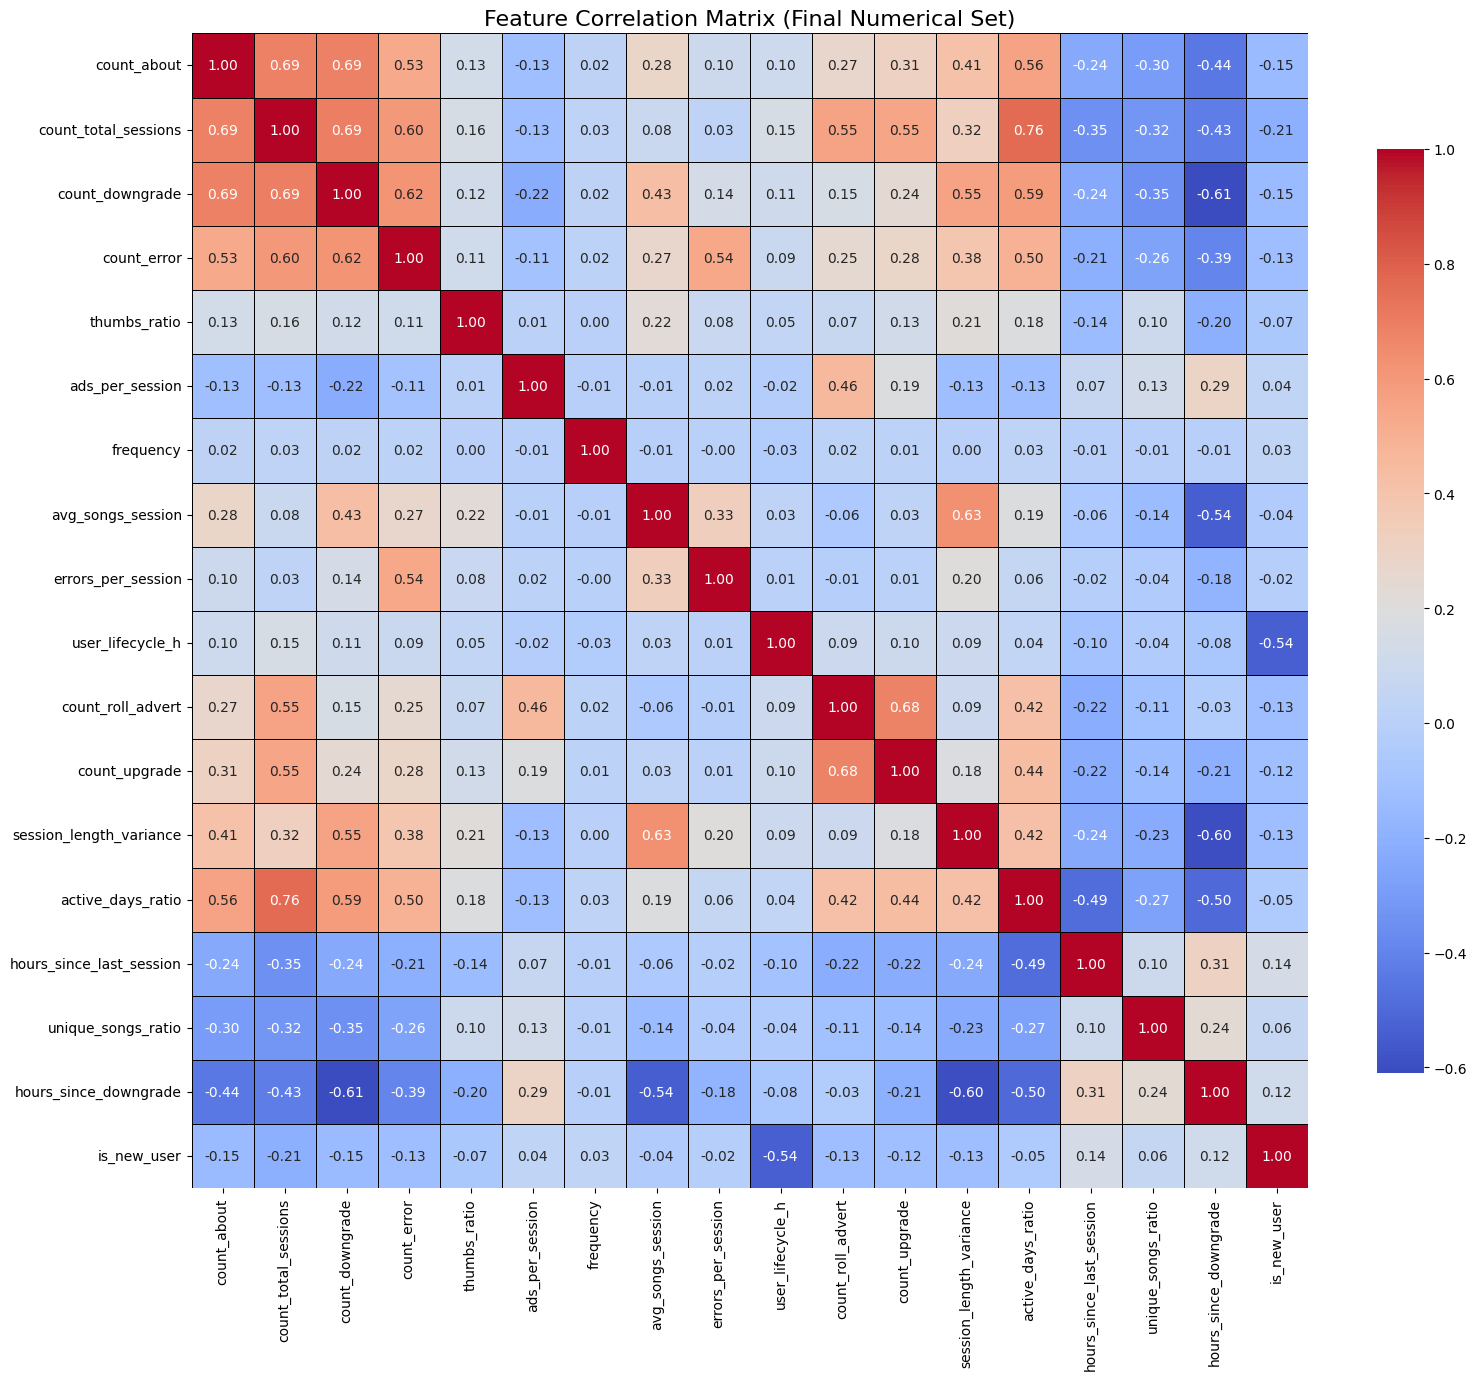

In [8]:
plt.figure(figsize=(18, 15))

# Create the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,         # Show the correlation numbers on the map
    cmap='coolwarm',    # Color map: cool=negative, warm=positive
    fmt=".2f",          # Format the numbers to two decimal places
    linewidths=0.5,     # Add lines between cells for clarity
    linecolor='black',
    cbar_kws={'shrink': 0.8} # Shrink color bar slightly
)

plt.title('Feature Correlation Matrix (Final Numerical Set)', fontsize=16)
plt.show()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from sklearn.ensemble import HistGradientBoostingClassifier

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), final_categorical_features)
    ],
    remainder="passthrough"
)

In [11]:
gbdt_model = HistGradientBoostingClassifier()

In [12]:
gbdt_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ("classifier", gbdt_model)
])

In [13]:
tscv = TimeSeriesSplit(n_splits=5)
scoring = {'F1': make_scorer(f1_score), 'AUC': make_scorer(roc_auc_score)}

In [15]:
gbdt_scores = cross_validate(
    gbdt_pipeline, 
    X, 
    y, 
    scoring=scoring, 
    cv=tscv, 
    n_jobs=-1
)

In [16]:
print(f"GBDT Mean F1 Score (Validation): {gbdt_scores['test_F1'].mean():.4f}")
print(f"GBDT Mean AUC Score (Validation): {gbdt_scores['test_AUC'].mean():.4f}")

GBDT Mean F1 Score (Validation): 0.0219
GBDT Mean AUC Score (Validation): 0.5050


In [24]:
print("=== DIAGNOSTIC REPORT ===")
print(f"Dataset shape: {df_final.shape}")
print(f"Feature matrix shape: {X.shape}")
print(f"Churn rate: {y.mean():.2%}")
print(f"Missing values: {X.isnull().sum().sum()}")
print(f"Constant features: {(X.nunique() == 1).sum()}")
print(f"\nSnapshot days: {sorted(df_final['snapshot_day'].unique())}")
print(f"Users per snapshot: {df_final.groupby('snapshot_day')['userId'].nunique().to_dict()}")

=== DIAGNOSTIC REPORT ===
Dataset shape: (60434, 47)
Feature matrix shape: (60434, 19)
Churn rate: 5.11%
Missing values: 0
Constant features: 0

Snapshot days: [9, 19, 29, 39]
Users per snapshot: {9: 14176, 19: 15452, 29: 15530, 39: 15276}


In [25]:
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\nFold {fold + 1}:")
    print(f"  Train: {len(train_idx)} samples, Churn rate: {y.iloc[train_idx].mean():.2%}")
    print(f"  Val: {len(val_idx)} samples, Churn rate: {y.iloc[val_idx].mean():.2%}")
    
    # Check if validation set has ANY churners
    if y.iloc[val_idx].sum() == 0:
        print("  ⚠️ WARNING: No churners in validation set!")


Fold 1:
  Train: 10074 samples, Churn rate: 5.53%
  Val: 10072 samples, Churn rate: 4.70%

Fold 2:
  Train: 20146 samples, Churn rate: 5.11%
  Val: 10072 samples, Churn rate: 4.12%

Fold 3:
  Train: 30218 samples, Churn rate: 4.78%
  Val: 10072 samples, Churn rate: 6.16%

Fold 4:
  Train: 40290 samples, Churn rate: 5.13%
  Val: 10072 samples, Churn rate: 5.55%

Fold 5:
  Train: 50362 samples, Churn rate: 5.21%
  Val: 10072 samples, Churn rate: 4.63%


In [27]:
# 1. Check TimeSeriesSplit behavior
print("=== TIME SERIES SPLIT ANALYSIS ===")
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\nFold {fold + 1}:")
    print(f"  Train size: {len(train_idx)}, Churn rate: {y.iloc[train_idx].mean():.2%}")
    print(f"  Val size: {len(val_idx)}, Churn rate: {y.iloc[val_idx].mean():.2%}")
    print(f"  Val churners: {y.iloc[val_idx].sum()}")
    
    # Check snapshot day distribution in train/val
    train_days = df_final.iloc[train_idx]['snapshot_day'].value_counts().sort_index()
    val_days = df_final.iloc[val_idx]['snapshot_day'].value_counts().sort_index()
    print(f"  Train snapshot days: {train_days.to_dict()}")
    print(f"  Val snapshot days: {val_days.to_dict()}")

# 2. Check individual feature predictive power
print("\n=== FEATURE PREDICTIVE POWER ===")
from sklearn.metrics import roc_auc_score

feature_aucs = {}
for col in final_numerical_features:
    if X[col].nunique() > 1:
        try:
            # Handle NaN and inf
            valid_mask = np.isfinite(X[col])
            if valid_mask.sum() > 0:
                auc = roc_auc_score(y[valid_mask], X[col][valid_mask])
                # Flip if < 0.5 (negative correlation is still predictive)
                auc = max(auc, 1 - auc)
                feature_aucs[col] = auc
        except Exception as e:
            print(f"{col}: Error - {e}")

# Sort by predictive power
feature_aucs_sorted = sorted(feature_aucs.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 most predictive features:")
for feat, auc in feature_aucs_sorted[:10]:
    print(f"  {feat}: {auc:.4f}")

print("\nBottom 5 least predictive features:")
for feat, auc in feature_aucs_sorted[-5:]:
    print(f"  {feat}: {auc:.4f}")

# 3. Check if there's overlap in users between train/val
print("\n=== USER OVERLAP CHECK ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    train_users = set(df_final.iloc[train_idx]['userId'])
    val_users = set(df_final.iloc[val_idx]['userId'])
    overlap = len(train_users & val_users)
    print(f"Fold {fold + 1}: {overlap} users appear in both train and val (out of {len(val_users)} val users)")
    if overlap > 0:
        print(f"  ⚠️ WARNING: {overlap/len(val_users):.1%} of validation users also in training!")

# 4. Check label distribution across snapshot days
print("\n=== LABEL DISTRIBUTION BY SNAPSHOT DAY ===")
print(df_final.groupby('snapshot_day')['label'].agg(['count', 'sum', lambda x: f"{x.mean():.2%}"]))

=== TIME SERIES SPLIT ANALYSIS ===

Fold 1:
  Train size: 10074, Churn rate: 5.53%
  Val size: 10072, Churn rate: 4.70%
  Val churners: 473
  Train snapshot days: {39: 10074}
  Val snapshot days: {29: 4870, 39: 5202}

Fold 2:
  Train size: 20146, Churn rate: 5.11%
  Val size: 10072, Churn rate: 4.12%
  Val churners: 415
  Train snapshot days: {29: 4870, 39: 15276}
  Val snapshot days: {29: 10072}

Fold 3:
  Train size: 30218, Churn rate: 4.78%
  Val size: 10072, Churn rate: 6.16%
  Val churners: 620
  Train snapshot days: {29: 14942, 39: 15276}
  Val snapshot days: {19: 9484, 29: 588}

Fold 4:
  Train size: 40290, Churn rate: 5.13%
  Val size: 10072, Churn rate: 5.55%
  Val churners: 559
  Train snapshot days: {19: 9484, 29: 15530, 39: 15276}
  Val snapshot days: {9: 4104, 19: 5968}

Fold 5:
  Train size: 50362, Churn rate: 5.21%
  Val size: 10072, Churn rate: 4.63%
  Val churners: 466
  Train snapshot days: {9: 4104, 19: 15452, 29: 15530, 39: 15276}
  Val snapshot days: {9: 10072}

==